### Brazilian E-Comm Analytics

**Goal** : Understand the db structure, check data quality, and prep for analysis

In [3]:
# Setup & Imports 
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

# db connection
conn = sqlite3.connect('../data/ecommerce.db')
print("Database connection established successfully!")

Database connection established successfully!


### DB Overview

In [ ]:
# Tables & Relations

tables_query = "SELECT name FROM sqlite_master WHERE type='table'"
tables = pd.read_sql_query(tables_query, conn)
print("Tables in the database:")
print(tables)

print("\n Table Sizes")
for table in tables['name']:
    count_query = f"SELECT COUNT(*) AS row_count FROM {table}"
    count = pd.read_sql(count_query, conn)['row_count'][0]
    print(f"Table '{table}': {count:>10,} rows")

Tables in the database:
                                name
0                          customers
1                        geolocation
2                        order_items
3                     order_payments
4                      order_reviews
5                             orders
6                           products
7                            sellers
8  product_category_name_translation

 Tabl Sizes
Table 'customers':     99,441 rows
Table 'geolocation':  1,000,163 rows
Table 'order_items':    112,650 rows
Table 'order_payments':    103,886 rows
Table 'order_reviews':     99,224 rows
Table 'orders':     99,441 rows
Table 'products':     32,951 rows
Table 'sellers':      3,095 rows
Table 'product_category_name_translation':         71 rows


### Exploring Each Tables

#### 1. Orders Table

In [9]:
# Orders Table

orders = pd.read_sql("SELECT * FROM orders LIMIT 10", conn)
print("Orders Table Structure:")
orders.head()

# Orrder status distribution
status_query = """
SELECT order_status, COUNT(*) as count,
       ROUND(COUNT(*) * 100.0 / (SELECT COUNT(*) FROM orders), 2) as percentage
FROM orders
GROUP BY order_status
ORDER BY count DESC
"""

status = pd.read_sql(status_query, conn)
print("\nOrder Status Distribution:")
print(status)



Orders Table Structure:

Order Status Distribution:
  order_status  count  percentage
0    delivered  96478       97.02
1      shipped   1107        1.11
2     canceled    625        0.63
3  unavailable    609        0.61
4     invoiced    314        0.32
5   processing    301        0.30
6      created      5        0.01
7     approved      2        0.00


#### 2. Order Review (Target Variable?)

In [10]:
# Score distribution
reviews_query = """
SELECT review_score, 
       COUNT(*) as count,
       ROUND(COUNT(*) * 100.0 / (SELECT COUNT(*) FROM order_reviews), 2) as percentage
FROM order_reviews
GROUP BY review_score
ORDER BY review_score DESC
"""

reviews = pd.read_sql(reviews_query, conn)
print("Review Score Distribution:")
print(reviews)

Review Score Distribution:
   review_score  count  percentage
0             5  57328       57.78
1             4  19142       19.29
2             3   8179        8.24
3             2   3151        3.18
4             1  11424       11.51


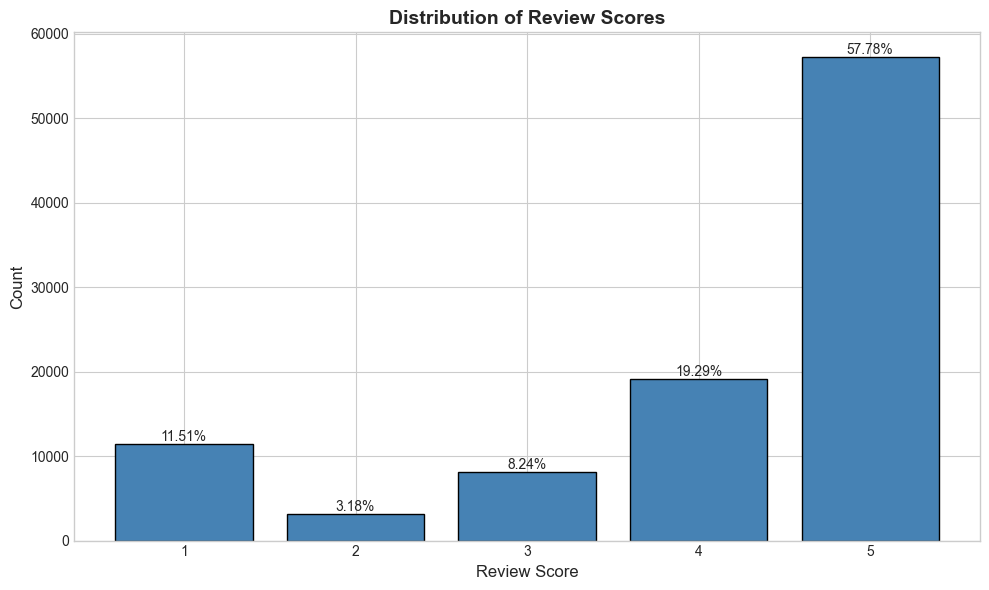


 Chart saved to reports/figures/review_distribution.png


In [11]:
# Review distribution visuals
plt.figure(figsize=(10, 6))
plt.bar(reviews['review_score'], reviews['count'], color='steelblue', edgecolor='black')
plt.xlabel('Review Score', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Distribution of Review Scores', fontsize=14, fontweight='bold')
plt.xticks(reviews['review_score'])

# Add percentage labels on bars
for i, row in reviews.iterrows():
    plt.text(row['review_score'], row['count'], f"{row['percentage']}%", 
             ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('../reports/figures/review_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n Chart saved to reports/figures/review_distribution.png")

#### 3. Customers & Geographic Distribution

In [12]:
# Top states by customer
states_query = """
SELECT customer_state, 
       COUNT(*) as customer_count
FROM customers
GROUP BY customer_state
ORDER BY customer_count DESC
LIMIT 10
"""

top_states = pd.read_sql(states_query, conn)
print("Top 10 States by Customer Count:")
print(top_states)

Top 10 States by Customer Count:
  customer_state  customer_count
0             SP           41746
1             RJ           12852
2             MG           11635
3             RS            5466
4             PR            5045
5             SC            3637
6             BA            3380
7             DF            2140
8             ES            2033
9             GO            2020


#### 4. Products & Categories

In [14]:
# Product categories check
categories = pd.read_sql("SELECT * FROM product_category_name_translation LIMIT 10", conn)
print("Product Categories (sample):")
print(categories)

print("\n")
# Count products by category
category_count = pd.read_sql("""
SELECT COUNT(DISTINCT product_category_name) as num_categories,
       COUNT(*) as num_products
FROM products
""", conn)

print(f"Total Categories: {category_count['num_categories'][0]}")
print(f"Total Products: {category_count['num_products'][0]:,}")



Product Categories (sample):
    product_category_name product_category_name_english
0            beleza_saude                 health_beauty
1  informatica_acessorios         computers_accessories
2              automotivo                          auto
3         cama_mesa_banho                bed_bath_table
4        moveis_decoracao               furniture_decor
5           esporte_lazer                sports_leisure
6              perfumaria                     perfumery
7   utilidades_domesticas                    housewares
8               telefonia                     telephony
9      relogios_presentes                 watches_gifts


Total Categories: 73
Total Products: 32,951


### Data Quality Checks

#### 1. Missing Values

In [15]:
# Missing delivery dates in orders
missing_query = """
SELECT 
    COUNT(*) as total_orders,
    SUM(CASE WHEN order_delivered_customer_date IS NULL THEN 1 ELSE 0 END) as missing_delivery_date,
    SUM(CASE WHEN order_estimated_delivery_date IS NULL THEN 1 ELSE 0 END) as missing_estimated_date
FROM orders
"""

missing = pd.read_sql(missing_query, conn)
print("Missing Values in Orders:")
print(missing)

print("\n")

# Check if all orders have reviews
review_coverage = pd.read_sql("""
SELECT 
    (SELECT COUNT(*) FROM orders WHERE order_status = 'delivered') as delivered_orders,
    (SELECT COUNT(DISTINCT order_id) FROM order_reviews) as orders_with_reviews
""", conn)

print("\nReview Coverage:")
print(review_coverage)
print(f"\nCoverage: {review_coverage['orders_with_reviews'][0] / review_coverage['delivered_orders'][0] * 100:.2f}%")

Missing Values in Orders:
   total_orders  missing_delivery_date  missing_estimated_date
0         99441                   2965                       0



Review Coverage:
   delivered_orders  orders_with_reviews
0             96478                98673

Coverage: 102.28%


#### Range & Anamolies

In [17]:
# Order date range
date_range = pd.read_sql("""
SELECT 
    MIN(order_purchase_timestamp) as first_order,
    MAX(order_purchase_timestamp) as last_order,
    COUNT(DISTINCT DATE(order_purchase_timestamp)) as unique_days
FROM orders
""", conn)

print("Order Date Range:")
print(date_range)

# Delivery time check
delivery_check = pd.read_sql("""
SELECT 
    COUNT(*) as total,
    AVG(JULIANDAY(order_delivered_customer_date) - JULIANDAY(order_purchase_timestamp)) as avg_delivery_days,
    MIN(JULIANDAY(order_delivered_customer_date) - JULIANDAY(order_purchase_timestamp)) as min_delivery_days,
    MAX(JULIANDAY(order_delivered_customer_date) - JULIANDAY(order_purchase_timestamp)) as max_delivery_days
FROM orders
WHERE order_status = 'delivered'
  AND order_delivered_customer_date IS NOT NULL
""", conn)

print("\nDelivery Time Statistics:")
print(delivery_check)


Order Date Range:
           first_order           last_order  unique_days
0  2016-09-04 21:15:19  2018-10-17 17:30:18          634

Delivery Time Statistics:
   total  avg_delivery_days  min_delivery_days  max_delivery_days
0  96470          12.558217           0.533414         209.628611


### Join Relationships

**Are Foreign Keys working properly?**

In [18]:
# Referential integrity checks
orphans_query = """
-- Orders without customers
SELECT 'Orders without customers' as check_type,
       COUNT(*) as count
FROM orders o
LEFT JOIN customers c ON o.customer_id = c.customer_id
WHERE c.customer_id IS NULL

UNION ALL

-- Order items without orders
SELECT 'Order items without orders' as check_type,
       COUNT(*) as count
FROM order_items oi
LEFT JOIN orders o ON oi.order_id = o.order_id
WHERE o.order_id IS NULL

UNION ALL

-- Order items without products
SELECT 'Order items without products' as check_type,
       COUNT(*) as count
FROM order_items oi
LEFT JOIN products p ON oi.product_id = p.product_id
WHERE p.product_id IS NULL
"""

orphans = pd.read_sql(orphans_query, conn)
print("Referential Integrity Checks:")
print(orphans)

Referential Integrity Checks:
                     check_type  count
0      Orders without customers      0
1    Order items without orders      0
2  Order items without products      0


### SQL View

**Creating View joining Orders, cust,reviews, & items for analysis**

In [19]:
# View creation for analysis
create_view_query = """
CREATE VIEW IF NOT EXISTS order_analysis AS
SELECT 
    o.order_id,
    o.customer_id,
    o.order_status,
    o.order_purchase_timestamp,
    o.order_delivered_customer_date,
    o.order_estimated_delivery_date,
    
    -- Delivery metrics
    JULIANDAY(o.order_delivered_customer_date) - JULIANDAY(o.order_purchase_timestamp) as actual_delivery_days,
    JULIANDAY(o.order_estimated_delivery_date) - JULIANDAY(o.order_purchase_timestamp) as estimated_delivery_days,
    JULIANDAY(o.order_delivered_customer_date) - JULIANDAY(o.order_estimated_delivery_date) as delivery_delay_days,
    CASE 
        WHEN JULIANDAY(o.order_delivered_customer_date) > JULIANDAY(o.order_estimated_delivery_date) THEN 1 
        ELSE 0 
    END as is_delayed,
    
    -- Customer info
    c.customer_state,
    c.customer_city,
    
    -- Review info
    r.review_score,
    CASE 
        WHEN r.review_score <= 3 THEN 1 
        ELSE 0 
    END as is_poor_review,
    
    -- Order value aggregates
    COUNT(DISTINCT oi.product_id) as num_items,
    SUM(oi.price) as total_price,
    SUM(oi.freight_value) as total_freight,
    SUM(oi.price + oi.freight_value) as total_order_value
    
FROM orders o
LEFT JOIN customers c ON o.customer_id = c.customer_id
LEFT JOIN order_reviews r ON o.order_id = r.order_id
LEFT JOIN order_items oi ON o.order_id = oi.order_id
GROUP BY o.order_id
"""

conn.execute(create_view_query)
print("✓ Created 'order_analysis' view")


# Test View
test_view = pd.read_sql("SELECT * FROM order_analysis LIMIT 5", conn)
print("\nSample from 'order_analysis' view:")
print(test_view)

✓ Created 'order_analysis' view

Sample from 'order_analysis' view:
                           order_id                       customer_id  \
0  00010242fe8c5a6d1ba2dd792cb16214  3ce436f183e68e07877b285a838db11a   
1  00018f77f2f0320c557190d7a144bdd3  f6dd3ec061db4e3987629fe6b26e5cce   
2  000229ec398224ef6ca0657da4fc703e  6489ae5e4333f3693df5ad4372dab6d3   
3  00024acbcdf0a6daa1e931b038114c75  d4eb9395c8c0431ee92fce09860c5a06   
4  00042b26cf59d7ce69dfabb4e55b4fd9  58dbd0b2d70206bf40e62cd34e84d795   

  order_status order_purchase_timestamp order_delivered_customer_date  \
0    delivered      2017-09-13 08:59:02           2017-09-20 23:43:48   
1    delivered      2017-04-26 10:53:06           2017-05-12 16:04:24   
2    delivered      2018-01-14 14:33:31           2018-01-22 13:19:16   
3    delivered      2018-08-08 10:00:35           2018-08-14 13:32:39   
4    delivered      2017-02-04 13:57:51           2017-03-01 16:42:31   

  order_estimated_delivery_date  actual_delivery_days 

### Summary & Data Quality Report

In [23]:
# Summary & Data Quality Report

print("Summary & Data Quality Report")
print("-" * 40)
print(f"Total Orders: {missing['total_orders'][0]:,}")
print(f"Orders with Missing Delivery Date: {missing['missing_delivery_date'][0]:,} ({missing['missing_delivery_date'][0] / missing['total_orders'][0] * 100:.2f}%)")
print(f"Orders with Missing Estimated Delivery Date: {missing['missing_estimated_date'][0]:,} ({missing['missing_estimated_date'][0] / missing['total_orders'][0] * 100:.2f}%)")
print(f"Review Coverage: {review_coverage['orders_with_reviews'][0] / review_coverage['delivered_orders'][0] * 100:.2f}%")
print(f"Date Range: {date_range['first_order'][0]} to {date_range['last_order'][0]} ({date_range['unique_days'][0]} unique days)")
print(f"Average Delivery Time: {delivery_check['avg_delivery_days'][0]:.2f} days")
print(f"Min Delivery Time: {delivery_check['min_delivery_days'][0]:.2f} days")
print(f"Max Delivery Time: {delivery_check['max_delivery_days'][0]:.2f} days")
print("\nReferential Integrity Issues:")
for i, row in orphans.iterrows():
    print(f"- {row['check_type']}: {row['count']:,} records")


# Close connection
conn.close()
print("\nDatabase connection closed!")



Summary & Data Quality Report
----------------------------------------
Total Orders: 99,441
Orders with Missing Delivery Date: 2,965 (2.98%)
Orders with Missing Estimated Delivery Date: 0 (0.00%)
Review Coverage: 102.28%
Date Range: 2016-09-04 21:15:19 to 2018-10-17 17:30:18 (634 unique days)
Average Delivery Time: 12.56 days
Min Delivery Time: 0.53 days
Max Delivery Time: 209.63 days

Referential Integrity Issues:
- Orders without customers: 0 records
- Order items without orders: 0 records
- Order items without products: 0 records

Database connection closed!
